In [8]:
import pandas as pd
data=pd.read_csv("FAOLEX.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [80]:
import nltk
keywords=list(data["Keywords"])
country=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    if type(country[i])!=str:
        country[i]="NaN"
    keywords[i]=words.split(";")
    i+=1



In [81]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [97]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']
Number of texts with two or less keywords 3104


# Top2vec topic model

In [18]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


/Users/gustavnielsen/Documents/Fagprojekt-1/top2vec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-29 12:55:36,474 - top2vec - INFO - Pre-processing documents for training
2023-05-29 12:55:43,271 - top2vec - INFO - Creating joint document/word embedding
2023-05-29 12:58:41,300 - top2vec - INFO - Creating lower dimension embedding of documents
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-05-29 13:10:16,130 - top2vec - INFO - Finding dense areas of documents
2023-05-29 13:10:22,232 - top2vec - INFO - Finding topics


In [19]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1310, 1281, 1270, ...,   21,   20,   17])

In [20]:
model.get_num_topics()

1167

In [42]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [43]:
print(topic_words)

[['maritime' 'continental' 'shelf' 'territorial' 'exclusive' 'eez' 'sea'
  'economic' 'zone' 'high' 'sovereignty' 'deep' 'seas' 'navigation'
  'fishing' 'foreign' 'vessel' 'marine' 'port' 'allowable' 'mesh'
  'transshipment' 'total' 'catch' 'coastal' 'harbour' 'bed' 'fisheries'
  'bycatch' 'cartilaginous' 'diadromous' 'fishes' 'method' 'charge'
  'mammals' 'exploration' 'fishery' 'illegal' 'migratory' 'iuu' 'landing'
  'stock' 'state' 'seasons' 'unreported' 'commercial' 'artisanal'
  'turtles' 'political' 'allocation']
 ['floriculture' 'seeds' 'plant' 'planting' 'material' 'fibre' 'variety'
  'legumes' 'oleaginous' 'breeders' 'vegetables' 'weeds' 'fruits'
  'edible' 'pests' 'nuts' 'timber' 'quarantine' 'grains' 'certification'
  'rice' 'viticulture' 'cereals' 'oenological' 'cane' 'tobacco'
  'diseases' 'beet' 'crops' 'wood' 'logging' 'production' 'labelling'
  'clearing' 'tea' 'internal' 'extraction' 'intellectual' 'steroids'
  'cocoa' 'genetic' 'forestry' 'hormones' 'afforestation' 's

In [98]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 55324, Score: 0.9786610007286072
-----------
marine fisheries fishing area molluscs seasons fishery management and conservation
-----------

Document: 52683, Score: 0.9735087752342224
-----------
marine fisheries molluscs seasons fishing area fishery management and conservation
-----------

Document: 26824, Score: 0.9723696708679199
-----------
marine fisheries molluscs seasons fishing area fishery management and conservation
-----------

Document: 38872, Score: 0.9719756841659546
-----------
fishery management and conservation marine fisheries molluscs fishing authorization
-----------

Document: 4186, Score: 0.9716467261314392
-----------
marine fisheries molluscs fishing gear/fishing method fishery management and conservation
-----------

Document: 1955, Score: 0.9713404178619385
-----------
marine fisheries molluscs fishing gear/fishing method fishery management and conservation
-----------

Document: 22752, Score: 0.9706137776374817
-----------
marine fisheries molluscs 

In [118]:
# Check documents
data.iloc[85707]

Record Id                                                     LEX-FAOC103851
Record URL                 http://www.fao.org/faolex/results/details/en/c...
Document URL                   https://faolex.fao.org/docs/pdf/bi-103851.pdf
Title                      Resolución Nº 4/011 - Fíjase en 6.500 tonelada...
Original title                                                           NaN
Date of original text                                             28-06-2011
Last amended date                                                        NaN
Available website                                                        NaN
Language of document                                                 Spanish
Country/Territory                                         Argentina; Uruguay
Regional organizations                                                 CTMFM
Territorial subdivision                                                  NaN
Type of text                                                       Agreement

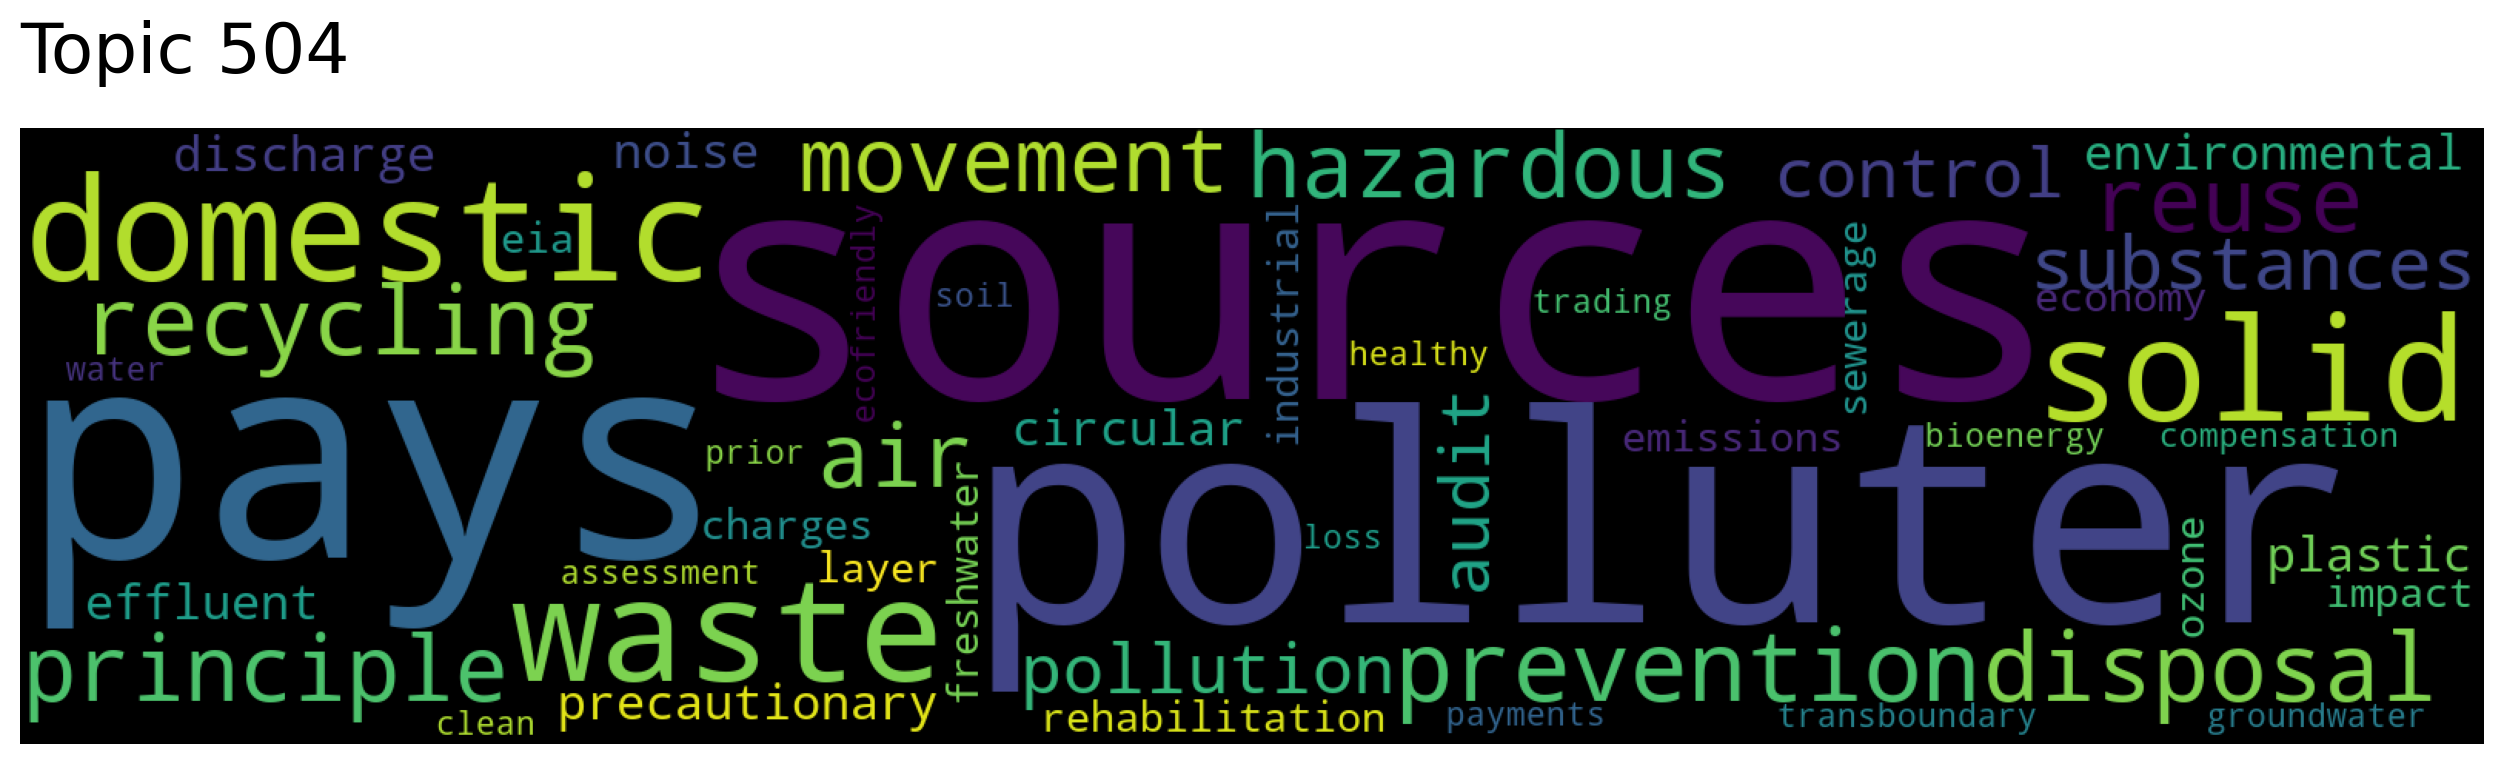

In [50]:
model.generate_topic_wordcloud(504)

In [100]:
# Look up topics corresponding to a keyword
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
print(topic_words)
print(topic_nums)
print(topic_scores)

[array(['sources', 'pays', 'polluter', 'domestic', 'waste', 'solid',
       'prevention', 'recycling', 'disposal', 'principle', 'reuse',
       'hazardous', 'movement', 'air', 'substances', 'pollution',
       'control', 'audit', 'precautionary', 'discharge', 'environmental',
       'effluent', 'plastic', 'noise', 'circular', 'rehabilitation',
       'ozone', 'charges', 'emissions', 'impact', 'freshwater',
       'industrial', 'economy', 'sewerage', 'eia', 'layer',
       'transboundary', 'compensation', 'clean', 'groundwater', 'soil',
       'payments', 'water', 'bioenergy', 'trading', 'assessment', 'prior',
       'ecofriendly', 'healthy', 'loss'], dtype='<U15'), array(['domestic', 'sources', 'solid', 'waste', 'prevention', 'disposal',
       'recycling', 'rehabilitation', 'reuse', 'hazardous', 'effluent',
       'discharge', 'substances', 'soil', 'movement', 'control',
       'pollution', 'pays', 'polluter', 'audit', 'erosion',
       'environmental', 'sewerage', 'improvement', 'pla

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [122]:
country_co_ocurrence = np.zeros((len(set(country)),len(set(country))))

In [123]:
topic_sizes, topic_nums = model.get_topic_sizes()
for num in topic_nums:
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        


0

In [117]:
topic_sizes, topic_nums = model.get_topic_sizes()
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=3,num_docs=topic_sizes[3])
for id in document_ids:
    print(country[id])

print(document_ids[13])


Norway
Peru
Peru
European Union
France
Peru
Peru
Belgium
Peru
Peru
Greenland (Denmark)
Peru
European Union
Argentina; Uruguay
Peru
France
Norway
Peru
Belgium
Greenland (Denmark)
Argentina
European Union
Belgium
Spain
European Union
Peru
Norway
Peru
Norway
Greenland (Denmark)
Finland
Norway
Norway
Italy
Chile
European Union
Peru
Peru
Argentina
Greenland (Denmark); Jan Mayen (Norway); Iceland
Norway
Belgium
Chile
European Union
Belgium
European Union
Argentina
Belgium
Norway
Peru
Chile
New Zealand
NaN
Argentina
Norway; Faroe Islands (Denmark)
Chile
European Union
Chile
Mexico
Russian Federation
Norway
European Union
Norway
Peru
Peru
Peru
Argentina
Peru
Argentina
Peru
Norway
European Union
Argentina
Norway
Belgium
Mexico
Italy
Italy
Chile
Portugal
New Zealand
Chile
Norway
Portugal
Norway
European Union
Norway
NaN
Norway
Argentina
Norway
Argentina
Argentina
Peru
Norway
Norway
European Union
Argentina; Uruguay
European Union
Ecuador
Italy
Chile
Greenland (Denmark)
NaN
European Union
Croatia

# Forskellige topic reduction

In [35]:
topic_mapping = model.hierarchical_topic_reduction(num_topics=200)

KeyboardInterrupt: 

In [197]:
print(model.topic_words_reduced)

[['steroids' 'hormones' 'mrl' 'residue' 'drugs' 'limit' 'hygiene'
  'maximum' 'swine' 'procedures' 'residues' 'sanitary' 'feed'
  'feedstuffs' 'veterinary' 'animal' 'toxicity' 'poultry' 'poisoning'
  'equine' 'slaughtering' 'meat' 'cattle' 'sheep' 'vaccination' 'goats'
  'additives' 'health' 'dairy' 'mercosur' 'safety' 'disinfestation'
  'codex' 'inspection' 'rodents' 'treated' 'haccp' 'disinfection'
  'andean' 'edible' 'packaging' 'pests' 'traceability' 'trade'
  'antimicrobial' 'diseases' 'welfare' 'labelling' 'milk' 'alimentarius']
 ['equine' 'sheep' 'swine' 'goats' 'cattle' 'rodents' 'herd' 'camelids'
  'book' 'reproduction' 'poultry' 'animal' 'slaughtering' 'vaccination'
  'mercosur' 'animals' 'welfare' 'meat' 'health' 'disinfestation' 'birds'
  'jersey' 'hygiene' 'sericulture' 'apiculture' 'steroids' 'hormones'
  'drugs' 'procedures' 'disinfection' 'quarantine' 'identification'
  'north' 'pests' 'feed' 'sanitary' 'ranching' 'inspection' 'marking'
  'captive' 'diseases' 'edible' '

In [202]:
model.topic_words_reduced[4]

array(['viticulture', 'oenological', 'tribunal', 'court', 'herzegovina',
       'beverages', 'tobacco', 'geographical', 'bosnia', 'indication',
       'fraud', 'settlement', 'codex', 'inspection', 'lao',
       'compensation', 'dispute', 'intellectual', 'labelling', 'trade',
       'certification', 'justice', 'practices', 'consumer', 'lanka',
       'liability', 'packaging', 'deceit', 'information', 'plant',
       'haccp', 'traceability', 'alimentarius', 'offences', 'internal',
       'tristan', 'adulteration', 'classification', 'singapore',
       'breeders', 'access', 'seeds', 'commodities', 'vested', 'sugar',
       'floriculture', 'veterinary', 'liechtenstein', 'legal',
       'agricultural'], dtype='<U14')

In [82]:
topic_words,word_scores,topic_nums = model.get_topics(10)
topic_words

array([['mesh', 'fishing', 'seasons', 'size', 'fishery', 'method',
        'cartilaginous', 'catch', 'bycatch', 'fisheries', 'landing',
        'prohibited', 'marine', 'total', 'allowable', 'charge',
        'allocation', 'fishes', 'vessel', 'gear', 'quota', 'artisanal',
        'foreign', 'commercial', 'diadromous', 'port', 'migratory',
        'transshipment', 'turtles', 'mammals', 'molluscs', 'crustaceans',
        'illegal', 'high', 'seas', 'inland', 'iuu', 'territorial',
        'unregulated', 'area', 'exclusive', 'state', 'eez',
        'enhancement', 'management', 'conservation', 'coral',
        'unreported', 'repopulation', 'sea'],
       ['floriculture', 'planting', 'seeds', 'material', 'fibre',
        'plant', 'cane', 'beet', 'variety', 'vegetables', 'breeders',
        'oleaginous', 'legumes', 'fruits', 'edible', 'nuts', 'sugar',
        'certification', 'rice', 'tobacco', 'cereals', 'labelling',
        'weeds', 'crops', 'oenological', 'production', 'packaging',
        '

# Data analyse

In [78]:
print(keywords[15])
print(len(keywords[15]))

marine fisheries traditional rights/customary rights fishing authorization allocation/quota fishery management and conservation
127


In [66]:
# Tæl hvor mange der er repealed inden for et dato interval
dates=data["Date of original text"]
repealed=data["Repealed"]
antal=0
for i in range(1800,2022):
    c=dates==str(i)
    d=repealed=="Y"
    antal+=sum(c*d)
print(antal)


965


In [ ]:
#Append country to keywords -- outdated
#i=0

#for words in keywords:
 #   keywords[i]=words + [" "+country[i]]
  #  i+=1

In [ ]:
# Find number of extinct domains
a= list(set(data["Domain"]))
i=0
for words in a:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    a[i]=words.split(";")

    i+=1

In [ ]:
# print different domains
a=sum(a,[])
i=0
for word in a:
        word=word.strip()
        a[i]=word
        i+=1

print(set(a))



In [ ]:
# Count number documents in a language
languages=list(data["Language of document"])
print(languages.count("English"))

In [109]:
print(len(set(country)))

2042


- Cluster topics
- Dendogram